In [4]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp   # pip install pandas-profiling
import seaborn as sns
import time
from matplotlib import pyplot as plt
%matplotlib inline

# traps = pd.read_csv('assets/train.csv')
# spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

# Preliminary EDA

In [2]:
# pdp.ProfileReport(traps)
# pdp.ProfileReport(spray)
# pdp.ProfileReport(weather)

# sns.pairplot(traps)
# sns.pairplot(spray)
# sns.pairplot(weather)

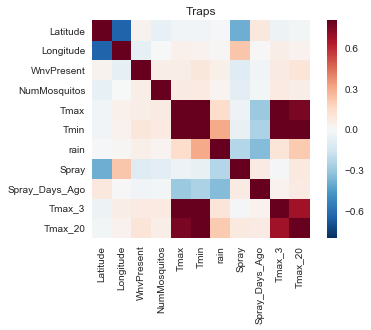

In [4]:
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

# Data Transformation

## Modify columns

In [6]:
# import datetime
# # Convert Date columns to actual date data type
traps.Date = pd.to_datetime(traps.Date)
# spray.Date = pd.to_datetime(spray.Date)
weather.Date = pd.to_datetime(weather.Date)

# # Create dummies for Species
# dummies = pd.get_dummies(traps, columns=['Species'])

# # Create a new df with the dummies
# traps_2_cols = traps.columns.drop('Species')
# traps_2 = pd.concat([traps[traps_2_cols],dummies])

# Weather data:
# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data
# 'PrecipTotal','Tavg'

def clean_col(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)


clean_col('Tavg')
clean_col('PrecipTotal')
clean_col('WetBulb')
clean_col('StnPressure')
clean_col('SeaLevel')
clean_col('AvgSpeed')


weather.CodeSum = weather.CodeSum.str.strip()
weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
weather.CodeSum[weather.CodeSum!='1'] = '0'
weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2


## Grouping records from same trap, same day inspection

In [35]:
# Because records are capped at 50 mosquitos,
# we are grouping the data to obtain a unique
# observation record per trap per date, with
# a total sum of NumMosquitos

traps = traps[['Trap',
               'Latitude',
               'Longitude',
               'Date',
               'Species',
               'WnvPresent',
               'NumMosquitos']].groupby(['Trap',
                                         'Latitude',
                                         'Longitude',
                                         'Date', 
                                         'Species',
                                         'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

In [128]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14,51,56.0,0,2,...,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,M,51,57.0,0,3,...,,M,M,M,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3,42,47.0,14,0,...,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,M,42,47.0,13,0,...,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2,40,48.0,9,0,...,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


## Applying the weather data to the dataframe

In [7]:
## This function takes three arguments:
## The column name as a string from weather dataframe that we want to extract
## a numpy function that we want to do to the data
## an integer number of previous days to extraxct

def weather_add(df, weather_col, func, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [9]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days.

traps['Tmax'] = weather_add(traps, weather_col='Tmax', func=np.mean)
traps['Tmin'] = weather_add(traps, weather_col='Tmin', func=np.mean)
traps['rain'] = weather_add(traps, weather_col='PrecipTotal', func= np.sum)
traps['Tmax_3'] = weather_add(traps, weather_col='Tmax', func=np.mean, days_range=3)
traps['Tmax_20'] = weather_add(traps, weather_col='Tmax',func=np.mean, days_range=20)

In [10]:
for col in ['Tavg','DewPoint','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    traps[col] = weather_add(traps, weather_col=col, func=np.mean)

## Applying the spray data to the dataframe

In [10]:
from geopy.distance import vincenty

def add_spray_data(traps):

    from geopy.distance import vincenty
    ## create a feature displaying the closest spray to the trap where applicable
    ## takes about 10 minutes to run so beware
    traps['Spray'] = np.NaN
    traps['Spray_Days_Ago'] = np.NaN

    ## get trap observations for dates with spray data
    traps_sprayed = traps[traps.Date>=min(spray.Date)].index.values

    start= datetime.datetime.now()
    print start

    remaining = len(traps_sprayed)

    for i in traps_sprayed:

        trap_lat = traps.Latitude.loc[i]
        trap_long = traps.Longitude.loc[i]
        # record the date of a week prior to the inspection
        trap_week_ago = traps.Date.loc[i] - pd.Timedelta(days=7)
        dist = []
        # for each dated trap inspection, select only the spray records within a week prior to the inspection
        spray_temp = spray[['Latitude','Longitude','Date']][(spray.Date >= trap_week_ago) & (spray.Date<=traps.Date.loc[i])]
        remaining-=1
        print str(remaining),' remaining'

        # run through each coordinate in the spray data and record the distance
        for j in range(0,len(spray_temp)):
            spray_lat = spray_temp.Latitude.iloc[j] 
            spray_long = spray_temp.Longitude.iloc[j]
            a = (trap_lat, trap_long)
            b = (spray_lat, spray_long)
            # calculate the distance between the points
            dist.append(vincenty(a, b).miles)
        try:
            # set the spray value to the shortest distance
            traps.Spray.loc[i] = min(dist)
            dt = dist.index(min(dist))
            spray_dt = spray_temp.Date.iloc[dt]
            traps['Spray_Days_Ago'].loc[i] = pd.Timedelta(traps.Date.loc[i]-spray_dt).days
        except:
            pass

    elapsed = datetime.datetime.now() - start
    print elapsed        

In [11]:
add_spray_data(traps)

2017-04-22 22:16:58.022789
2546  remaining
2545  remaining
2544  remaining
2543  remaining
2542  remaining
2541  remaining
2540  remaining
2539  remaining
2538  remaining
2537  remaining
2536  remaining
2535  remaining
2534  remaining
2533  remaining
2532  remaining
2531  remaining
2530  remaining
2529  remaining
2528  remaining
2527  remaining
2526  remaining
2525  remaining
2524  remaining
2523  remaining
2522  remaining
2521  remaining
2520  remaining
2519  remaining
2518  remaining
2517  remaining
2516  remaining
2515  remaining
2514  remaining
2513  remaining
2512  remaining
2511  remaining
2510  remaining
2509  remaining
2508  remaining
2507  remaining
2506  remaining
2505  remaining
2504  remaining
2503  remaining
2502  remaining
2501  remaining
2500  remaining
2499  remaining
2498  remaining
2497  remaining
2496  remaining
2495  remaining
2494  remaining
2493  remaining
2492  remaining
2491  remaining
2490  remaining
2489  remaining
2488  remaining
2487  remaining
2486  remaini

In [ ]:
# traps.to_csv('/Users/jennydoyle/Desktop/dsi/West-Nile-Virus-Prediction/assets/traps_spray_distance.csv',sep=',', encoding='utf-8')

In [132]:
## Check out how the correlation map changes with our new features
find_correlation(traps, 'Traps')

NameError: name 'find_correlation' is not defined

## Scale the Data 

In [27]:
traps[traps.rain.isnull()]

# Index([u'Trap', u'Latitude', u'Longitude', u'Date', u'Species', u'WnvPresent',
#        u'NumMosquitos', u'Tmax', u'Tmin', u'rain', u'Spray', u'Spray_Days_Ago',
#        u'Tmax_3', u'Tmax_20', u'Tavg', u'DewPoint', u'WetBulb', u'CodeSum',
#        u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
# #       dtype='object')


,Trap,Latitude,Longitude,Date,Species,WnvPresent,NumMosquitos,Tmax,Tmin,rain,...,Tmax_20,Tavg,DewPoint,WetBulb,CodeSum,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago'])
features
# traps[features].head()

traps_rescaled = pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)
# traps_rescaled = pd.concat(traps_rescaled, traps[['Species','Date','Trap']])
traps_rescaled


,Latitude,Longitude,WnvPresent,NumMosquitos,Tmax,Tmin,rain,Tmax_3,Tmax_20,Tavg,DewPoint,WetBulb,CodeSum,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,0.829072,0.493342,0.0,0.000000,0.585062,0.605201,0.185120,0.587591,0.708075,0.573410,0.522936,0.570720,9.901000e-01,0.975037,0.952285,0.527179,0.371429,0.650619
1,0.829072,0.493342,0.0,0.000000,0.829876,0.765957,0.165633,0.810219,0.653209,0.786127,0.674312,0.719603,9.999000e-01,0.933932,0.880425,0.586667,0.790476,0.796424
2,0.829072,0.493342,0.0,0.000000,0.614108,0.574468,0.279008,0.649635,0.663561,0.573410,0.490826,0.540943,9.000001e-04,0.939424,0.891348,0.494359,0.733333,0.723521
3,0.829072,0.493342,0.0,0.000000,0.763485,0.723404,0.114703,0.817518,0.668737,0.730636,0.662844,0.707196,9.999990e-03,0.956399,0.918655,0.296410,0.215873,0.288858
4,0.829072,0.493342,0.0,0.000907,0.763485,0.723404,0.114703,0.817518,0.668737,0.730636,0.662844,0.707196,9.999990e-03,0.956399,0.918655,0.296410,0.215873,0.288858
5,0.829072,0.493342,0.0,0.000000,0.863071,0.822695,0.365810,0.766423,0.752588,0.836994,0.784404,0.826303,9.090010e-03,0.946580,0.902558,0.186667,0.304762,0.193948
6,0.829072,0.493342,0.0,0.000000,0.863071,0.822695,0.365810,0.766423,0.752588,0.836994,0.784404,0.826303,9.090010e-03,0.946580,0.902558,0.186667,0.304762,0.193948
7,0.829072,0.493342,0.0,0.001814,0.738589,0.801418,0.274579,0.660584,0.819876,0.756069,0.844037,0.826303,9.999910e-01,0.953736,0.912906,0.080000,0.231746,0.181568
8,0.829072,0.493342,0.0,0.001814,0.738589,0.801418,0.274579,0.660584,0.819876,0.756069,0.844037,0.826303,9.999910e-01,0.953736,0.912906,0.080000,0.231746,0.181568
9,0.829072,0.493342,0.0,0.000000,0.500000,0.647754,0.575288,0.423358,0.711180,0.547977,0.729358,0.677419,9.999990e-01,0.958729,0.924116,0.210256,0.361905,0.290234


In [ ]:
## Save the transformed files so we don't have to run the earlier cells

# traps.to_csv('./assets/Train_transformed/traps.csv', encoding='utf-8', index=False)

In [5]:
##re-import the altered traps file

traps = pd.read_csv('./assets/Train_transformed/traps.csv')
traps.drop('Unnamed: 0',axis=1,inplace=True)

# Feature Selection

In [13]:
traps.head(2)

,Trap,Latitude,Longitude,Date,Species,WnvPresent,NumMosquitos,Tmax,Tmin,rain,Tmax_3,Tmax_20,Spray,Spray_Days_Ago
0,T001,41.953705,-87.733974,2007-06-26,CULEX PIPIENS/RESTUANS,0,1,80.1875,64.3125,2.09,80.625,83.428571,NaN,NaN
1,T001,41.953705,-87.733974,2007-07-11,CULEX PIPIENS/RESTUANS,0,1,87.5625,68.5625,1.87,88.250,82.166667,NaN,NaN


In [40]:
features = ['rain','Tmax_3','Tmax_20']

In [41]:
traps['Spray'].isnull().sum()/float(len(traps['Spray']))

0.8283391405342625

In [13]:
X = traps[features]

In [14]:
y = traps.WnvPresent

# Building the Models

## Random Forest

performs at .57
performs at .59 with Tmin, rain, Tmax_3 and Tmax_20

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=0)


In [27]:
RF = RandomForestClassifier(n_estimators = 500, bootstrap=True, max_depth=4,
                            max_features='auto',min_samples_leaf= 1, min_samples_split= 3)

In [28]:
RF_model= RF.fit(X_train,y_train)

In [29]:
RF_model.score(X_train,y_train)

1.0

### Random Forest Grid Search

In [39]:
grid_search_params = { 'max_features' : ['auto',None],
                    'max_depth':[None, 1, 5, 3],
                    'min_samples_split':[2,3,5],
                    'min_samples_leaf':[1,2,5],
                    'bootstrap':[True, False]
    
}

In [40]:
gs = GridSearchCV(RF, grid_search_params)

In [41]:
k = gs.fit(X,y)

In [42]:
k.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [43]:
k.score(X,y)

1.0

## Support Vector Machine

Currently performing at .50 (bad)

In [44]:
from sklearn.svm import SVC

In [45]:
svmc= SVC(probability=True)

In [46]:
svm_model = svmc.fit(X,y)

In [47]:
grid_search_params = { 'C' : [1,2,3.01,.001],
                    'kernel':['rbf', 'linear','poly']
}

In [ ]:
gsvm = GridSearchCV(svmc, grid_search_params)

In [ ]:
svm = gsvm.fit(X,y)

In [ ]:
svm.best_params_

In [ ]:
svm.score(X,y)

## ADA Boost

currently performs at .51

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost= AdaBoostClassifier()

In [ ]:
ada_model=adaboost.fit(X,y)

In [ ]:
adaboost.score(X,y)

# Import and Transform Test Data

In [21]:
test = pd.read_csv('assets/test.csv')

In [22]:
### converting datetime

test.Date = pd.to_datetime(test.Date)


In [24]:
## Applying weather data
test['Tmax'] = weather_add(test, weather_col='Tmax', func=np.mean)
test['Tmin'] = weather_add(test, weather_col='Tmin', func=np.mean)
test['rain'] = weather_add(test, weather_col='PrecipTotal', func= np.sum)
test['Tmax_3'] = weather_add(test, weather_col='Tmax', func=np.mean, days_range=3)
test['Tmax_20'] = weather_add(test, weather_col='Tmax',func=np.mean, days_range=20)

## Spray data
add_spray_data(test)

2017-04-22 22:36:09.832950
49237  remaining
49236  remaining
49235  remaining
49234  remaining
49233  remaining
49232  remaining
49231  remaining
49230  remaining
49229  remaining
49228  remaining
49227  remaining
49226  remaining
49225  remaining
49224  remaining
49223  remaining
49222  remaining
49221  remaining
49220  remaining
49219  remaining
49218  remaining
49217  remaining
49216  remaining
49215  remaining
49214  remaining
49213  remaining
49212  remaining
49211  remaining
49210  remaining
49209  remaining
49208  remaining
49207  remaining
49206  remaining
49205  remaining
49204  remaining
49203  remaining
49202  remaining
49201  remaining
49200  remaining
49199  remaining
49198  remaining
49197  remaining
49196  remaining
49195  remaining
49194  remaining
49193  remaining
49192  remaining
49191  remaining
49190  remaining
49189  remaining
49188  remaining
49187  remaining
49186  remaining
49185  remaining
49184  remaining
49183  remaining
49182  remaining
49181  remaining
4918

In [66]:
## Export the tranformed test data to a folder in the repo 
## so we don't have to run the above cells evert time

test.to_csv('./assets/Test_transformed/test_transformed.csv',sep=',', encoding='utf-8')

In [67]:
test = pd.read_csv('./assets/Test_transformed/test_transformed.csv')

In [25]:
test.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Tmax,Tmin,rain,Tmax_3,Tmax_20,Spray,Spray_Days_Ago
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,82.75,64.5625,4.015,81.375,74.833333,NaN,NaN
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,82.75,64.5625,4.015,81.375,74.833333,NaN,NaN


In [47]:
test_X = test[features]

# Exporting to test

In [27]:
###This function will takes a model and a model name(as a string), generate predictions, 
### and save that as a CSV labeled with the model name and date.
import time 
import math
def model_and_export(model, model_name):
    predictions = ["%.1f" % (math.ceil(x[1] * 100) / 100) for x in model.predict_proba(test_X)]
    indexes=np.arange(1, len(predictions)+1, 1)
    preds_df = pd.DataFrame(data=[indexes, predictions]).T
    preds_df.columns =['Id','WnvPresent']
    location = './submissions/{}_{}.csv'.format(model_name, time.strftime("%d_%m_%Y"))
    preds_df.to_csv(location, index=False)
    return
    

In [48]:
model_and_export(RF_model, 'RF_test')

In [77]:
model_and_export(svm_model, 'SVM')

You can test the model by submitting the results CSV to :

https://www.kaggle.com/c/predict-west-nile-virus/submit

please note that only 5 submission can be made per day. 

Make note of the model and score below:




In [28]:
model_and_export(ada_model, 'ADABoost')